In [146]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [29]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', 'pplSIT', 'workflow', 'utils'))

In [147]:
np.set_printoptions(suppress=True)

In [30]:
%matplotlib inline

#from session.adapters import DatProcessor
from neurosuite import XMLHero, DatHero
import matplotlib.pyplot as plt
import numpy as np
import h5py
import json
from scipy import signal

In [343]:
sessions = [
    #"57_SIT_2023-12-18_14-07-34", no pulses in ephys
#     "57_SIT_2023-12-18_21-17-56", # broken session
#    "57_SIT_2023-12-19_14-15-26",  # broken session - too small
    "57_SIT_2023-12-21_15-05-52",
    "57_SIT_2023-12-22_14-08-07",
    "57_SIT_2023-12-22_14-43-58",
    "57_SIT_2023-12-22_17-37-18",
    "57_SIT_2023-12-23_14-21-01",
    "57_SIT_2023-12-23_14-56-24", # broken session
    "57_SIT_2023-12-28_16-43-28",
    "57_SIT_2023-12-29_11-06-26",
    "57_SIT_2023-12-29_11-40-14",
    "57_SIT_2023-12-29_12-11-46",
    "57_SIT_2024-01-02_14-43-18",
    "57_SIT_2024-01-02_16-38-05",
    "57_SIT_2024-01-02_17-10-09",
    "57_SIT_2024-01-03_19-22-18",
    "57_SIT_2024-01-03_19-54-59",
    "57_SIT_2024-01-04_14-16-22",
    "57_SIT_2024-01-04_14-52-59",
    "57_SIT_2024-01-05_14-35-49",
    "57_SIT_2024-01-05_15-08-34",
    "57_SIT_2024-01-06_16-52-40",
    "57_SIT_2024-01-06_17-25-35",
    "57_SIT_2024-01-07_19-23-28",
    "57_SIT_2024-01-07_19-59-26",
    "57_SIT_2024-01-08_15-51-26",
    "57_SIT_2024-01-12_13-23-02",
    "57_SIT_2024-01-15_13-45-22",
    "57_SIT_2024-01-15_14-34-48",
    "57_SIT_2024-01-31_17-00-39",
    "57_SIT_2024-02-01_15-51-41",
    "57_SIT_2024-02-05_13-10-00",
    "57_SIT_2024-03-11_14-45-37"
]

sessions

['57_SIT_2023-12-21_15-05-52',
 '57_SIT_2023-12-22_14-08-07',
 '57_SIT_2023-12-22_14-43-58',
 '57_SIT_2023-12-22_17-37-18',
 '57_SIT_2023-12-23_14-21-01',
 '57_SIT_2023-12-23_14-56-24',
 '57_SIT_2023-12-28_16-43-28',
 '57_SIT_2023-12-29_11-06-26',
 '57_SIT_2023-12-29_11-40-14',
 '57_SIT_2023-12-29_12-11-46',
 '57_SIT_2024-01-02_14-43-18',
 '57_SIT_2024-01-02_16-38-05',
 '57_SIT_2024-01-02_17-10-09',
 '57_SIT_2024-01-03_19-22-18',
 '57_SIT_2024-01-03_19-54-59',
 '57_SIT_2024-01-04_14-16-22',
 '57_SIT_2024-01-04_14-52-59',
 '57_SIT_2024-01-05_14-35-49',
 '57_SIT_2024-01-05_15-08-34',
 '57_SIT_2024-01-06_16-52-40',
 '57_SIT_2024-01-06_17-25-35',
 '57_SIT_2024-01-07_19-23-28',
 '57_SIT_2024-01-07_19-59-26',
 '57_SIT_2024-01-08_15-51-26',
 '57_SIT_2024-01-12_13-23-02',
 '57_SIT_2024-01-15_13-45-22',
 '57_SIT_2024-01-15_14-34-48',
 '57_SIT_2024-01-31_17-00-39',
 '57_SIT_2024-02-01_15-51-41',
 '57_SIT_2024-02-05_13-10-00',
 '57_SIT_2024-03-11_14-45-37']

## Quick update of manual.json

In [344]:
raw = '/home/sobolev/nevermind/AG_Pecka/data/raw/'

for session in sessions:
    animal = session.split('_')[0]
    man_file = os.path.join(src, animal, session, 'manual.json')
    
    with open(man_file, 'r') as json_file:
        data = json.load(json_file)
    data['ephys']['offset'] = {
            "type": "ephys",
            "file_type": "dat",
            "channel": "64"
        }
    
    with open(man_file, 'w') as json_file:
        json_string = json.dumps(data, default=lambda o: o.__dict__, sort_keys=True, indent=4)
        json_file.write(json_string)

## Build events from ephys + sounds.csv

In [319]:
#def get_pulse_times(xml_file, dat_file, channel):
src = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
raw = '/home/sobolev/nevermind/AG_Pecka/data/raw/'

session = sessions[2]
animal = session.split('_')[0]
meta_file = os.path.join(src, animal, session, 'meta.h5')
dat_file  = os.path.join(src, animal, session, 'neurosuite', '%s.dat' % session)
xml_file  = os.path.join(src, animal, session, 'neurosuite', '%s.xml' % session)
sounds_file  = os.path.join(raw, animal, session, 'sounds.csv')
events_file  = os.path.join(raw, animal, session, 'events.csv')

In [320]:
ev_ephys, ev_synced = get_sound_events_from_ephys(dat_file, xml_file, sounds_file, events_file)

In [322]:
ev_ephys, ev_synced

(array([[   0.25846667,    0.3091    ],
        [   0.50793333,    0.55873333],
        [   0.75763333,    0.80833333],
        ...,
        [1799.30023333, 1799.3508    ],
        [1799.55133333, 1799.60126667],
        [1799.8012    , 1799.85176667]]),
 array([[   0.25846667,    1.        ],
        [   0.50793333,    1.        ],
        [   0.75763333,    1.        ],
        ...,
        [1799.55133333,    1.        ],
        [1799.8012    ,    1.        ],
        [1800.00095415,    1.        ]]))

(array([   1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    1.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,
           0.,    0.,    1.,    2.,    0.,   18., 4759., 2407.,    4.,
           0.,    1.,    2.,    0.,    0.,    0.,    0.,    0.,    0.,
           1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    1.]),
 array([0.16044449, 0.16404117, 0.16763785, 0.17123453, 0.1748312 ,
        0.17842788, 0.18202456, 0.18562124, 0.18921792, 0.1928146 ,
        0.19641127, 0.20000795, 0.20360463, 0.20720131, 0.21079799,
        0.21439467, 0.21799134, 0.22158802, 0.2251847 , 0.22878138,
        0.23237806, 0.23597474, 0.23957141, 0.24316809, 0.24676477,
        0.25036145, 0.25395813, 0.25755481, 0.26115149, 0.26474816,
        0.26834484, 0.27194152, 0.2755382 , 0.27913488, 0.28273156,
        0.28632823, 0.28992491, 0.29352159, 0.29711827, 0.30071495,
        0.30431163, 0.3079083 , 0.31150498, 0.31510166, 

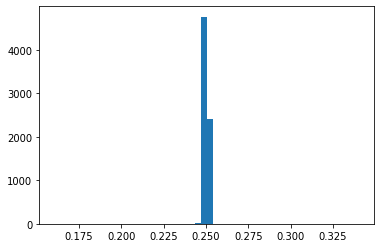

In [301]:
diffs = np.diff(events_updated[:, 0])

plt.hist(diffs, bins=50)

## Playground

In [80]:
data.shape

(54001920,)

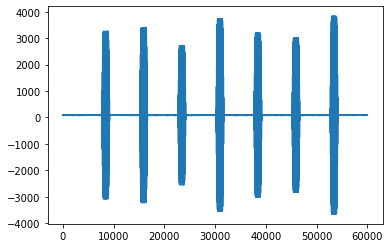

In [34]:
plt.plot(data[:60000])

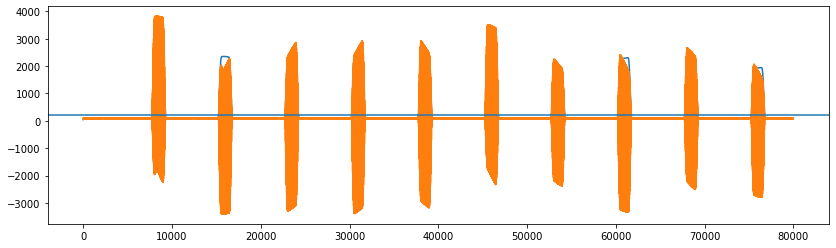

In [308]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(data_smooth[0:80000])
ax.plot(data[0:80000])
ax.axhline(thresh)

In [187]:
periods = []

idxs_diff = np.diff(idxs_high)
period_idxs = np.where((idxs_diff > 3))[0]

for i, idx in enumerate(period_idxs):
    if i == 0:
        pair = (idxs_high[0], idxs_high[idx])
    else:
        pair = (idxs_high[period_idxs[i - 1] + 1], idxs_high[idx])
    periods.append(pair)

# add the last period (ignoring events that were still happening at the end of recording)
if not idxs_high[-1] == len(data_smooth):
    periods.append((idxs_high[period_idxs[-1] + 1], idxs_high[-1]))

periods = np.array(periods)/30000.

#if idxs_high[-1] - idxs_high[period_idxs[-1]] > 2:  # more than 2 secs
#    periods.append((idxs_high[period_idxs[-1] + 1], idxs_high[-1]))

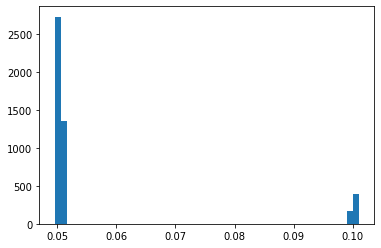

In [189]:
durations = np.diff(periods, axis=1)
durations = durations.T[0]

_ = plt.hist(durations[durations < 0.2], bins=50)

In [114]:
#periods[733]/30000., periods[733]
#plt.plot(data_smooth[6922000:6923000])

In [200]:
with h5py.File(meta_file, 'r') as f:
    events = np.array(f['processed']['sound_events'])
    
events_csv = np.loadtxt(sounds_file, skiprows=1, delimiter=',')
events_csv[:, 0] = events_csv[:, 0] - 1703167580.3885756

In [192]:
# event statistics
ev_BGR = events[events[:, 1] == 1]
ev_TGT = events[events[:, 1] == 2]
ev_NOI = events[events[:, 1] == -1]
ev_TRI = events[(events[:, 1] == 1) | (events[:, 1] == 2)]

print("BGR: %d, TGT: %d, TRI: %d" % (len(ev_BGR), len(ev_TGT), len(ev_TRI)))
print("All: %s" % str(len(ev_BGR) + len(ev_TGT) + len(ev_NOI)))

BGR: 4098, TGT: 548, TRI: 4646
All: 5077


In [196]:
# ephys event stats

#pl_BGR = periods[(durations > 0.03) & (durations < 0.07)]
#pl_TGT = periods[(durations > 2700) & (durations < 3300)]
#pl_NOI = periods[(durations > 280000) & (durations < 310000)]
pl_TRI = periods[durations < 0.22]
pl_NOI = periods[durations > 0.22]

print("BGR: %d, TGT: %d, NOI: %d" % (len(pl_BGR), len(pl_TGT), len(pl_NOI)))
print("Recognized: %s, ALL: %d" % (len(pl_TRI), len(durations)))

BGR: 0, TGT: 0, NOI: 11
Recognized: 4650, ALL: 4661


In [195]:
BGR_diffs = ev_TRI[:, 0] - pl_TRI[:len(ev_TRI), 0]
plt.plot(BGR_diffs)

ValueError: operands could not be broadcast together with shapes (4646,) (0,) 

In [173]:
np.where(BGR_diffs > 15)

(array([ 996, 1037, 1074, 1314, 1554, 1811, 1864, 1906, 1959, 2046, 2286,
        2466, 2467, 2552, 2553, 2678, 2679, 2680, 2918, 2919, 2920, 3158,
        3159, 3160, 3366, 3367, 3368, 3606, 3607, 3608, 3700, 3701, 3702,
        3940, 3941, 3942, 3970, 3971, 3972, 4120, 4121, 4122, 4123, 4263,
        4264, 4265, 4266, 4503, 4504, 4505, 4506]),)

In [148]:
ev_BGR[228:232], pl_BGR[228:232, 0]/30000.

(array([[  59.50688452,    1.        , 5952.        ],
        [  59.75690483,    1.        , 5977.        ],
        [  60.00692539,    1.        , 6002.        ],
        [  83.25783645,    1.        , 8327.        ]]),
 array([59.75923333, 60.00626667, 83.25753333, 83.50713333]))

In [149]:
ev_BGR[100:105], pl_BGR[100:105]/30009.

(array([[  27.50625417,    1.        , 2752.        ],
        [  27.75627448,    1.        , 2777.        ],
        [  28.00629504,    1.        , 2802.        ],
        [  28.2563156 ,    1.        , 2827.        ],
        [  28.50633615,    1.        , 2852.        ]]),
 array([[27.7481089 , 27.79909361],
        [27.99870039, 28.04835216],
        [28.24965844, 28.29981006],
        [28.49898364, 28.54970176],
        [28.74770902, 28.79762738]]))

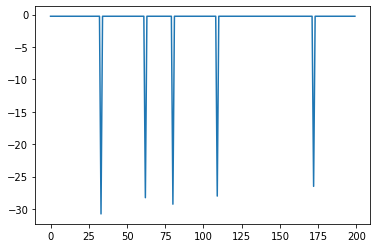

In [167]:
plt.plot(ev_BGR[1600:1800, 0] - pl_BGR[1600:1800, 0]/30000.)

In [180]:
ev_TRI[994:998], pl_TRI[994:998]/30000.

(array([[  342.76416745,     2.        , 34277.        ],
        [  343.01418824,     2.        , 34302.        ],
        [  367.01516097,     1.        , 36703.        ],
        [  367.2641816 ,     1.        , 36727.        ]]),
 array([[342.76483333, 342.8648    ],
        [343.015     , 343.11526667],
        [343.2651    , 343.3648    ],
        [367.01473333, 367.0647    ]]))

In [179]:
events_csv[events_csv[:, 1] > 0][994:997]

array([[342.74860382,   2.        ],
       [342.99861836,   2.        ],
       [366.99899101,   1.        ]])

In [182]:
events_csv, ev_TRI

(array([[   0.24801397,    1.        ],
        [   0.49802828,    1.        ],
        [   0.74804258,    1.        ],
        ...,
        [1799.24891114,    1.        ],
        [1799.49892521,    1.        ],
        [1799.74893951,    1.        ]]),
 array([[     0.25501397,      1.        ,     27.        ],
        [     0.50503453,      1.        ,     52.        ],
        [     0.75505509,      1.        ,     77.        ],
        ...,
        [  1799.30089206,      1.        , 179931.        ],
        [  1799.55091238,      1.        , 179956.        ],
        [  1799.80093294,      1.        , 179981.        ]]))

In [133]:
BGR_diffs.sum()

-4687.517870645878

In [130]:
ev_BGR[:len(pl_BGR), 0]

array([2.55013973e-01, 5.05034529e-01, 7.55055085e-01, ...,
       1.79780077e+03, 1.79805079e+03, 1.79830081e+03])

In [131]:
pl_BGR[:, 0]/30000.

array([2.56200000e-01, 5.05000000e-01, 7.56866667e-01, ...,
       1.79929810e+03, 1.79954680e+03, 1.79979783e+03])

In [27]:
# TODO: find why there is such a mismatch in the number of pulses coming from
# the events.csv and from the Ephys file !!!

In [72]:
periods.dtype

dtype('int64')

In [78]:
(periods[-5:]/30000.)

array([[1798.79733333, 1798.84813333],
       [1799.0486    , 1799.0988    ],
       [1799.2981    , 1799.34813333],
       [1799.5468    , 1799.59783333],
       [1799.79783333, 1799.84796667]])

In [77]:
events[-5:]

array([[1.79880085e+03, 1.00000000e+00, 1.79881000e+05],
       [1.79905087e+03, 1.00000000e+00, 1.79906000e+05],
       [1.79930089e+03, 1.00000000e+00, 1.79931000e+05],
       [1.79955091e+03, 1.00000000e+00, 1.79956000e+05],
       [1.79980093e+03, 1.00000000e+00, 1.79981000e+05]])

In [91]:
events_csv[-5:]

array([[1.79874888e+03, 1.00000000e+00],
       [1.79899890e+03, 1.00000000e+00],
       [1.79924891e+03, 1.00000000e+00],
       [1.79949893e+03, 1.00000000e+00],
       [1.79974894e+03, 1.00000000e+00]])

In [277]:
np.where(diffs < 0.06)

(array([804]),)

(array([   1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    1.,    1.,    1.,    1.,    3., 5305., 1880.,    0.,
           1.,    1.,    1.,    1.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    1.]),
 array([0.05893333, 0.066594  , 0.07425467, 0.08191533, 0.089576  ,
        0.09723667, 0.10489733, 0.112558  , 0.12021867, 0.12787933,
        0.13554   , 0.14320067, 0.15086133, 0.158522  , 0.16618267,
        0.17384333, 0.181504  , 0.18916467, 0.19682533, 0.204486  ,
        0.21214667, 0.21980733, 0.227468  , 0.23512867, 0.24278933,
        0.25045   , 0.25811067, 0.26577133, 0.273432  , 0.28109267,
        0.28875333, 0.296414  , 0.30407467, 0.31173533, 0.319396  ,
        0.32705667, 0.33471733, 0.342378  , 0.35003867, 0.35769933,
        0.36536   , 0.37302067, 0.38068133, 0.388342  , 

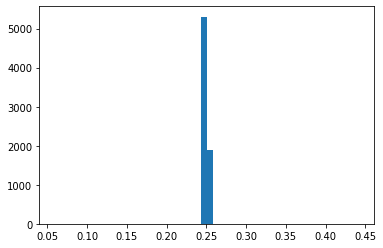

In [276]:
diffs = np.diff(events_updated[:, 0])

plt.hist(diffs, bins=50)

In [280]:
events_updated[800:850]

array([[200.26086667,   1.        ],
       [200.50986667,   1.        ],
       [200.76463333,   1.        ],
       [201.01066667,   1.        ],
       [201.45263333,   1.        ],
       [201.51156667,   1.        ],
       [201.75976667,   1.        ],
       [202.0108    ,   1.        ],
       [202.26046667,   1.        ],
       [202.5113    ,   1.        ],
       [202.76216667,   1.        ],
       [203.0104    ,   1.        ],
       [203.26173333,   1.        ],
       [203.5108    ,   1.        ],
       [203.762     ,   1.        ],
       [204.0103    ,   1.        ],
       [204.2608    ,   1.        ],
       [204.5125    ,   1.        ],
       [204.76013333,   1.        ],
       [205.01133333,   1.        ],
       [205.2616    ,   1.        ],
       [205.512     ,   1.        ],
       [205.76016667,   1.        ],
       [206.01103333,   1.        ],
       [206.26033333,   1.        ],
       [206.51223333,   1.        ],
       [206.76236667,   1.        ],
 

In [248]:
events_csv[900:1100]

array([[225.24888349,   1.        ],
       [225.49889755,   1.        ],
       [225.7489121 ,   1.        ],
       [225.99892616,   1.        ],
       [226.24894047,   1.        ],
       [226.49895501,   1.        ],
       [226.74896908,   1.        ],
       [226.99898338,   1.        ],
       [227.24899793,   1.        ],
       [227.49801183,   1.        ],
       [227.74802637,   1.        ],
       [227.99804044,   1.        ],
       [228.24805498,   1.        ],
       [228.49806929,   1.        ],
       [228.74808335,   1.        ],
       [228.9980979 ,   1.        ],
       [229.24811196,   1.        ],
       [229.49812627,   1.        ],
       [229.74814081,   1.        ],
       [229.99815488,   1.        ],
       [230.24816918,   1.        ],
       [230.49818373,  -1.        ],
       [230.74819779,  -1.        ],
       [230.9982121 ,  -1.        ],
       [231.2482264 ,  -1.        ],
       [231.49824071,  -1.        ],
       [231.74825525,  -1.        ],
 

(17455776.0, 17515776.0)

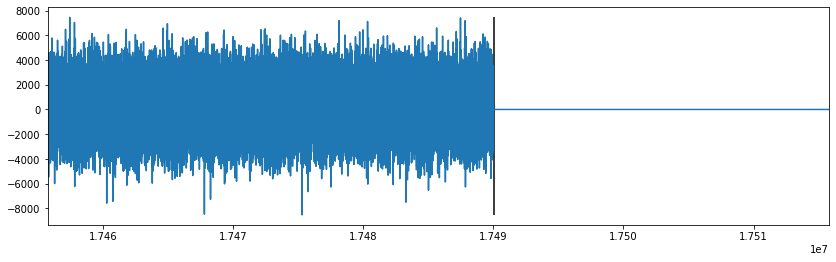

In [81]:
fig, ax = plt.subplots(figsize=(14, 4))

dur = 60000

ax.plot(data)
ax.vlines(periods[:, 0], ymin=data.min(), ymax=data.max(), color='red')
ax.vlines(periods[:, 1], ymin=data.min(), ymax=data.max(), color='black')
ax.set_xlim(len(data_smooth) - dur, len(data_smooth))

In [58]:
data.mean(), data[:5000].std(), data.max()

(88.54534312382164, 9.322358566371495, 7459.0)

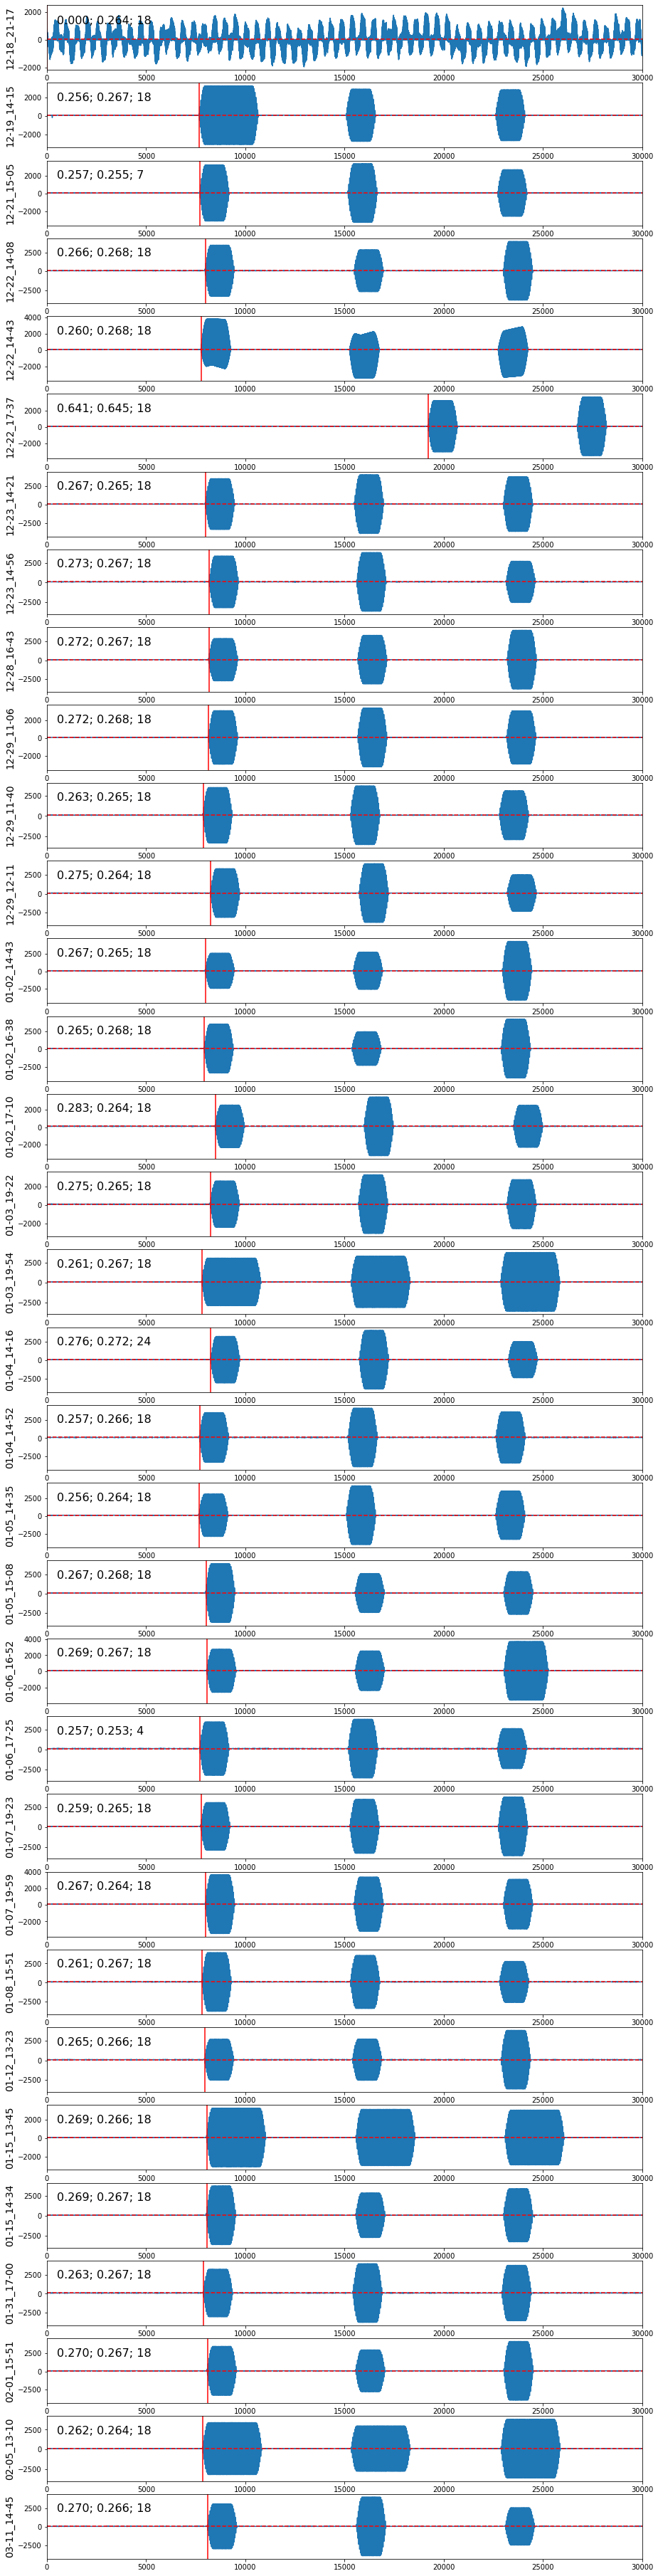

In [66]:
src = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
raw = '/home/sobolev/nevermind/AG_Pecka/data/raw/'
selected = sessions[:]
s_rate = 30000

fig, axes = plt.subplots(len(selected), 1, figsize=(15, 2*len(selected)))

for i, session in enumerate(selected):
    animal = session.split('_')[0]
    meta_file = os.path.join(src, animal, session, 'meta.h5')
    dat_file  = os.path.join(src, animal, session, 'neurosuite', '%s.dat' % session)
    xml_file  = os.path.join(src, animal, session, 'neurosuite', '%s.xml' % session)
    man_file  = os.path.join(raw, animal, session, 'manual.json')
    
    with h5py.File(meta_file, 'r') as f:
        events = np.array(f['processed']['sound_events'])
    with open(man_file, 'r') as f:
        manual = json.load(f)
        
    dp = DatProcessor(dat_file, channel_count=72)
    b1 = dp.read_block_from_dat(1, 0)
    
    sig = b1[:, 64]
    x_l, x_r = 0, 15000
    idxs_tone = np.where(np.abs(sig - sig.mean()) > 0.1*sig.max())[0]
    idx_first_pulse_start = idxs_tone[0]
    
    ax = axes[i]
    ax.plot(sig)
    ax.axhline(sig.mean(), color='red', ls='--')
    ax.axvline(idx_first_pulse_start, color='red')
    ax.set_xlim(0, len(sig))
    ax.text(500, 0.5*sig.max(), "%.3f; %.3f; %d" % (
        float(idx_first_pulse_start/s_rate), 
        events[0][0],
        manual['ephys']['offset']
    ), fontsize=16)
    ax.set_ylabel(session[-14:-3], fontsize=14)

In [67]:
r_path = '/home/sobolev/nevermind/Andrey/analysis'

fig.savefig(os.path.join(r_path, 'sync', '%s_first_pulse_onset.pdf' % animal))